In [1]:
! pip install diffusers transformers accelerate wandb open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
  

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from diffusers import DDPMPipeline,DDIMScheduler
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
model_id = "google/ddpm-celebahq-256"
image_pipe = DDPMPipeline.from_pretrained(model_id).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

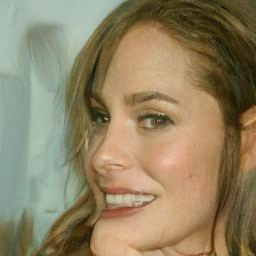

In [6]:
images = image_pipe().images
images[0]

In [7]:
scheduler = DDIMScheduler.from_pretrained(model_id)
scheduler.set_timesteps(num_inference_steps=40)

In [8]:
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

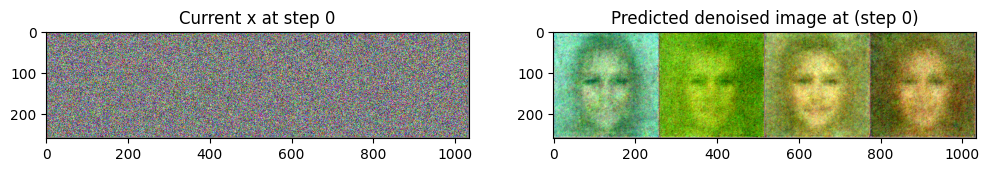

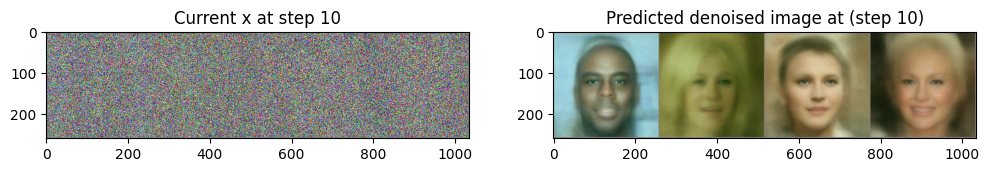

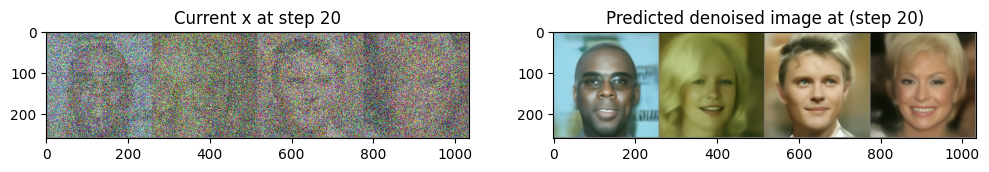

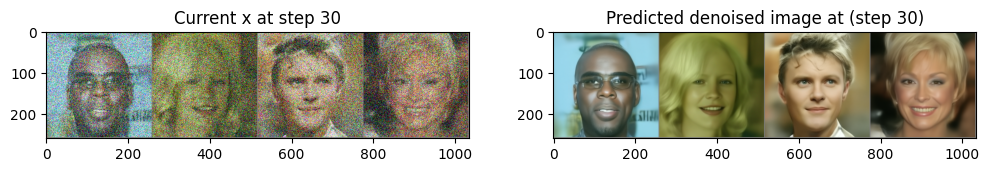

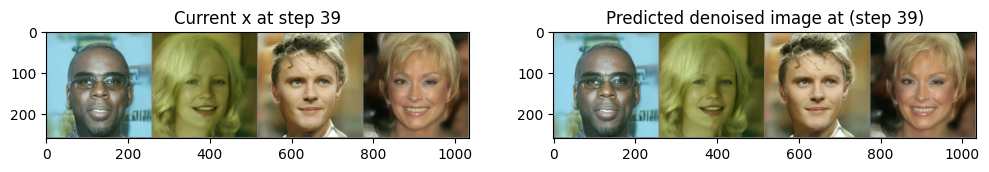

In [18]:
x = torch.randn(4,3,256,256).to(device)

for i,t in enumerate(scheduler.timesteps):
    model_input = scheduler.scale_model_input(sample=x,timestep=t)

    with torch.no_grad():
        noise_pred = image_pipe.unet(sample=model_input,timestep=t)['sample']

    scheduler_output = scheduler.step(noise_pred,t,x)
    x = scheduler_output.prev_sample

    if i % 10 == 0 or i == len(scheduler.timesteps)-1:
        fig,axs = plt.subplots(1,2,figsize=(12,5))
        grid = torchvision.utils.make_grid(x,nrow=4).permute(1,2,0)
        axs[0].set_title(f'Current x at step {i}')
        axs[0].imshow(grid.cpu().clip(-1,1)*0.5 + 0.5)

        pred_x0 = (scheduler_output.pred_original_sample)
        grid = torchvision.utils.make_grid(pred_x0,nrow=4).permute(1,2,0)
        axs[1].imshow(grid.cpu().clip(-1,1)*0.5 + 0.5)
        axs[1].set_title(f'Predicted denoised image at (step {i})')
        plt.show()


  0%|          | 0/40 [00:00<?, ?it/s]

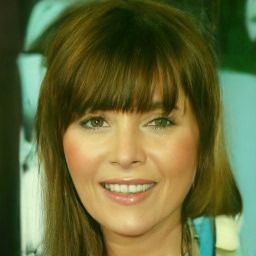

In [19]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

In [21]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.6 MB/s eta 0:00:00


In [22]:
from datasets import load_dataset

dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(dataset_name,split='train')

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Previewing batch:


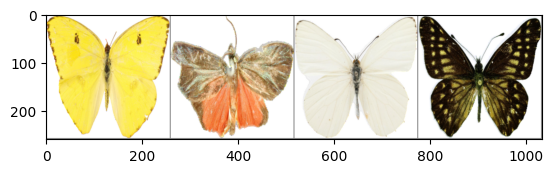

In [23]:
image_size = 256
batch_size = 4
preprocess = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images':images}


dataset.set_transform(transform)
train_dataloader =  torch.utils.data.DataLoader(dataset,
                                                batch_size=batch_size,
                                                shuffle=True)
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.013297154458006845


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.01302615745345247


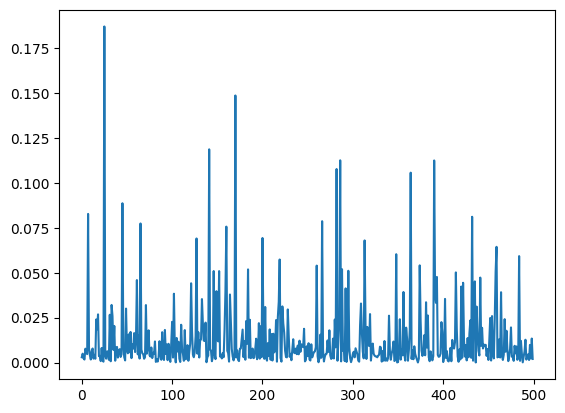

In [26]:
import os

num_epochs = 2
lr = 1e-5
grad_accumulation_steps = 2
checkpoint_path = 'model_checkpoint.pth'

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(),lr=lr)
losses = []
start_epoch = 0

if os.path.exists(checkpoint_path):
    print("Resuming from checkpoint")
    checkpoint = torch.load(checkpoint_path,map_location=device)
    image_pipe.unet.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
    print(f"Checkpoint loaded resuming from epoch {start_epoch}")

for epoch in range(num_epochs):
    epoch_loss = 0

    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        clean_images = batch['images'].to(device)
        noise = torch.randn_like(clean_images).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps = torch.randint(0,image_pipe.scheduler.num_train_timesteps,(bs,),device=clean_images.device).long()
        noisy_images = image_pipe.scheduler.add_noise(clean_images,noise,timesteps)

        noise_pred = image_pipe.unet(noisy_images,timesteps,return_dict=False)[0]
        loss = F.mse_loss(noise_pred,noise)
        loss.backward()
        losses.append(loss.item())
        epoch_loss += loss.item()

        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
    avg_loss = epoch_loss / len(train_dataloader)
    checkpoint = {'epoch':epoch,
                  'model_state_dict':image_pipe.unet.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'losses':losses}
    torch.save(checkpoint,checkpoint_path)

    print(f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")

plt.plot(losses)
plt.show()

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
device =  accelerator.device

num_epochs = 2
losses = []
model = image_pipe.unet
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)
start_epoch = 0

model,optimizer,train_dataloader = accelerator.prepare(model,optimizer,train_dataloader)

if os.path.exists(checkpoint_path):
    print("Resuming from checkpoint")
    checkpoint = torch.load(checkpoint_path,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    losses = checkpoint['losses']
    print(f"checkpoint loaded resuming from epoch {start_epoch}")

for epoch in range(start_epoch,num_epochs):
    epoch_loss = 0

    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        clean_images = batch['images'].to(device)
        noise = torch.randn_like(clean_images).to(clean_images.device)
        bs = clean_images.shape[0]

        timesteps = torch.randint(0,image_pipe.unet.scheduler.num_train_timesteps,(bs,),
                                  device=clean_images.device).long()
        noisy_images = image_pipe.scheduler.add_noise(clean_images,noise,timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images,timesteps,return_dict=False)[0]
            loss = F.mse_loss(noise_pred,noise)
            accelerator.backward(loss)

            if (step + 1) % grad_accumulation_steps == 0: